# Searching for contributed COSMOS images

This notebook tutorial demonstrates the process of querying IRSA's Simple Image Access (SIA) service for the COSMOS images, making a cutout image (thumbnail), and displaying the cutout.

## Learning Goals

By the end of this tutorial, you will:

* Learn how to search the NASA Astronomical Virtual Observatory Directory web portal for a service that provides access to IRSA's COSMOS images.
* Use the Python pyvo package to identify which of IRSA's COSMOS images cover a specified coordinate.
* Download one of the identified images.
* Create and display a cutout of the downloaded image.

## Introduction

The COSMOS Archive serves data taken for the Cosmic Evolution Survey with HST (COSMOS) project, using IRSA's general search service, Atlas. COSMOS is an HST Treasury Project to survey a 2 square degree equatorial field with the ACS camera. For more information about COSMOS, see:

https://irsa.ipac.caltech.edu/Missions/cosmos.html

The [NASA/IPAC Infrared Science Archive (IRSA)](https://irsa.ipac.caltech.edu) at Caltech is one of the archives for COSMOS images and catalogs. The COSMOS images that are the subject of this tutorial are made accessible via the [International Virtual Observatory Alliance (IVOA)](https://ivoa.net) [Simple Image Access (SIA)](https://wiki.ivoa.net/internal/IVOA/SiaInterface/SIA-V2-Analysis.pdf) protocol. IRSA's SEIP SIA service is registered in the NASA Astronomical Virtual Observatory (NAVO) [Directory](https://vao.stsci.edu). Based on the registered information, the Python package [pyvo](https://pyvo.readthedocs.io) can be used to query the SIA service for a list of images that meet specified criteria, and standard Python libraries can be used to download and manipulate the images.
Other datasets at IRSA are available through other SIA services:

https://irsa.ipac.caltech.edu/docs/program_interface/api_images.html

## Imports

- *pyvo* for querying IRSA's COSMOS SIA service
- *astropy.coordinates* for defining coordinates
- *astropy.nddata* for creating an image cutout
- *astropy.wcs* for interpreting the World Coordinate System header keywords of a fits file
- *astropy.units* for attaching units to numbers passed to the SIA service
- *matplotlib.pyplot* for plotting
- *astropy.utils.data* for downloading files
- *astropy.io* to manipulate FITS files

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install matplotlib astropy pyvo

In [2]:
import pyvo as vo
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits

## Section 1 - Setup

Set images to display in the notebook

In [3]:
%matplotlib inline

Define coordinates of a bright source

In [4]:
ra = 149.99986
dec = 2.24875
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

## Section 2 - Lookup and define a service for COSMOS images

Start at STScI VAO Registry at https://vao.stsci.edu/keyword-search/

Limit by Publisher "NASA/IPAC Infrared Science Archive" and Capability Type "Simple Image Access Protocol" then search on "COSMOS"

Locate the SIA2 URL https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=COSMOS&hdr_location=%5CCOSMOSDataPath%5C&collection_desc=Cosmic+Evolution+Survey+with+HST+%28COSMOS%29&SIAP_ACTIVE=1&

In [5]:
cosmos_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=COSMOS&hdr_location=%5CCOSMOSDataPath%5C&collection_desc=Cosmic+Evolution+Survey+with+HST+%28COSMOS%29&SIAP_ACTIVE=1&")

## Section 3 - Search the service

Search for images covering within 1 arcsecond of the star

In [6]:
im_table = cosmos_service.search(pos=pos, size=1.0*u.arcsec)

Inspect the table of images that is returned

In [7]:
im_table

<DALResultsTable length=279>
   ra   ...
  deg   ...
float64 ...
------- ...
150.014 ...
150.022 ...
150.014 ...
150.022 ...
149.977 ...
149.977 ...
150.061 ...
150.061 ...
150.116 ...
    ... ...
150.061 ...
150.061 ...
150.061 ...
150.061 ...
150.061 ...
150.061 ...
150.061 ...
150.061 ...
149.995 ...

In [8]:
im_table.to_table().colnames

['ra',
 'dec',
 'cra',
 'cdec',
 'naxis1',
 'naxis2',
 'ctype1',
 'ctype2',
 'crval1',
 'crval2',
 'crpix1',
 'crpix2',
 'cdelt1',
 'cdelt2',
 'crota2',
 'ra1',
 'dec1',
 'ra2',
 'dec2',
 'ra3',
 'dec3',
 'ra4',
 'dec4',
 'equinox',
 'hdu',
 'facility_name',
 'instrument_name',
 'dataproduct_type',
 'file_type',
 'band_name',
 'wavelength',
 'access_estsize',
 's_fov',
 'tile',
 'fname',
 'dataset',
 'cutout',
 'sia_desc',
 'sia_naxes',
 'sia_naxis',
 'sia_scale',
 'sia_cdmatrix',
 'sia_format',
 'sia_url']

View the first ten entries of the table

In [9]:
im_table.to_table()[:10]

ra,dec,cra,cdec,naxis1,naxis2,ctype1,ctype2,crval1,crval2,crpix1,crpix2,cdelt1,cdelt2,crota2,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,equinox,hdu,facility_name,instrument_name,dataproduct_type,file_type,band_name,wavelength,access_estsize,s_fov,tile,fname,dataset,cutout,sia_desc,sia_naxes,sia_naxis,sia_scale,sia_cdmatrix,sia_format,sia_url
deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,object,object,int32,int32,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,object,object,object,object,object,float64,int32,float64,int32,object,object,object,object,int32,object,object,object,object,object
150.014,2.224,10h 00m 03.41s,+02d 13m 27.3s,7500,7500,RA---TAN,DEC--TAN,150.0142269,2.224247,3750.0,3750.0,-8.3333333333e-06,8.3333333333e-06,260.2377156,149.9781089,2.1987513,150.0397491,2.188154,150.0503559,2.2497487,149.9887132,2.2603465,2000.0,0,HST,ACS,image,science,I,8.0874e-07,225043,0.0625,-99,images/acs_2.0/I/acs_I_100003+0213_unrot_sci_20.fits,HST-ACS,YES,Cosmic Evolution Survey with HST (COSMOS),2,[7500 7500],[-8.3333333333e-06 8.3333333333e-06],[-8.33333e-06 -0.0 -0.0 8.33333e-06],image/fits,https://irsa.ipac.caltech.edu:443/cgi-bin/Subimage/nph-subimage?origfile=/irsadata/COSMOS//images%2Facs_2.0%2FI%2Facs_I_100003%2B0213_unrot_sci_20.fits&ra=149.999860&dec=2.248750&xsize=0.000278
150.022,2.276,10h 00m 05.35s,+02d 16m 32.8s,7500,7500,RA---TAN,DEC--TAN,150.0223083,2.2757825,3750.0,3750.0,-8.3333333333e-06,8.3333333333e-06,260.2376781,149.9861889,2.2502868,150.0478312,2.2396894,150.0584385,2.3012841,149.9967936,2.3118819,2000.0,0,HST,ACS,image,science,I,8.0874e-07,225043,0.0625,-99,images/acs_2.0/I/acs_I_100005+0216_unrot_sci_20.fits,HST-ACS,YES,Cosmic Evolution Survey with HST (COSMOS),2,[7500 7500],[-8.3333333333e-06 8.3333333333e-06],[-8.33333e-06 -0.0 -0.0 8.33333e-06],image/fits,https://irsa.ipac.caltech.edu:443/cgi-bin/Subimage/nph-subimage?origfile=/irsadata/COSMOS//images%2Facs_2.0%2FI%2Facs_I_100005%2B0216_unrot_sci_20.fits&ra=149.999860&dec=2.248750&xsize=0.000278
150.014,2.224,10h 00m 03.41s,+02d 13m 27.3s,7500,7500,RA---TAN,DEC--TAN,150.0142269,2.224247,3750.0,3750.0,-8.3333333333e-06,8.3333333333e-06,260.2377156,149.9781089,2.1987513,150.0397491,2.188154,150.0503559,2.2497487,149.9887132,2.2603465,2000.0,0,HST,ACS,image,weight,I,8.0874e-07,225043,0.0625,-99,images/acs_2.0/I/acs_I_100003+0213_unrot_wht_20.fits,HST-ACS,YES,Cosmic Evolution Survey with HST (COSMOS),2,[7500 7500],[-8.3333333333e-06 8.3333333333e-06],[-8.33333e-06 -0.0 -0.0 8.33333e-06],image/fits,https://irsa.ipac.caltech.edu:443/cgi-bin/Subimage/nph-subimage?origfile=/irsadata/COSMOS//images%2Facs_2.0%2FI%2Facs_I_100003%2B0213_unrot_wht_20.fits&ra=149.999860&dec=2.248750&xsize=0.000278
150.022,2.276,10h 00m 05.35s,+02d 16m 32.8s,7500,7500,RA---TAN,DEC--TAN,150.0223083,2.2757825,3750.0,3750.0,-8.3333333333e-06,8.3333333333e-06,260.2376781,149.9861889,2.2502868,150.0478312,2.2396894,150.0584385,2.3012841,149.9967936,2.3118819,2000.0,0,HST,ACS,image,weight,I,8.0874e-07,225043,0.0625,-99,images/acs_2.0/I/acs_I_100005+0216_unrot_wht_20.fits,HST-ACS,YES,Cosmic Evolution Survey with HST (COSMOS),2,[7500 7500],[-8.3333333333e-06 8.3333333333e-06],[-8.33333e-06 -0.0 -0.0 8.33333e-06],image/fits,https://irsa.ipac.caltech.edu:443/cgi-bin/Subimage/nph-subimage?origfile=/irsadata/COSMOS//images%2Facs_2.0%2FI%2Facs_I_100005%2B0216_unrot_wht_20.fits&ra=149.999860&dec=2.248750&xsize=0.000278
149.977,2.210,09h 59m 54.57s,+02d 12m 34.5s,4096,4096,RA---TAN,DEC--TAN,150.1163213,2.2009731,-1284.5,1841.0,-4.166666832e-05,4.166666832e-05,0.0,150.0627846,2.124243,149.8919601,2.1242277,149.8919344,2.2949346,150.0627784,2.2949512,2000.0,0,CFHT,MegaPrime,image,uncertainty,u,3.798e-07,67115,0.170667,66,images/cfht/u/original_psf/cfht_u_066_rms_50.fits,CFHT,NO,Cosmic Evolution Survey with HST (COSMOS),2,[4096 4096],[-4.166666832e-05 4.166666832e-05],[-4.16667e-05 -0.0 -0.0

## Section 4 - Locate and download an image of interest

Locate the first image in the band_name of i+

In [10]:
for i in range(len(im_table)):
    if im_table[i]['band_name'] == 'i+':
        break
print(im_table[i].getdataurl())

https://irsa.ipac.caltech.edu:443/data/COSMOS/images/subaru/best_psf/ip/subaru_ip_best-psf_066_rms_20.fits


Download the image

In [11]:
fname = download_file(im_table[i].getdataurl(), cache=True)
image1 = fits.open(fname)

## Section 5 - Extract a cutout and plot it

In [12]:
wcs = WCS(image1[0].header)

Make a cutout centered on the position

In [13]:
cutout = Cutout2D(image1[0].data, pos, (60, 60), wcs=wcs)
wcs = cutout.wcs

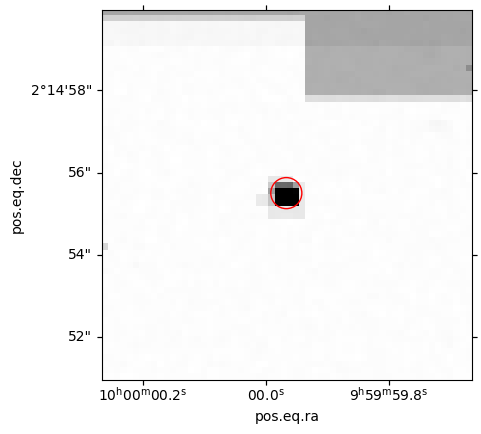

In [14]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(cutout.data, cmap='gray_r', origin='lower')
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

***

## About this notebook

**Author:** David Shupe, IRSA Scientist, and the IRSA Science Team

**Updated:** 2022-02-14

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.

## Citations

If you use `astropy` for published research, please cite the authors. Follow these links for more information about citing `astropy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

If you use COSMOS ACS imaging data in published research,  please cite the dataset Digital Object Identifier (DOI): [10.26131/IRSA178](https://www.ipac.caltech.edu/doi/irsa/10.26131/IRSA178).